# Lab 3 Fraud detection with Trees

Fraud is a massive problem for financial institutions and one of the foremost reasons to leveraged machine learning in finance.

Data source: https://www.kaggle.com/mlg-ulb/creditcardfraud

The datasets contains transactions made by credit cards in September 2013 by european cardholders. 
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

# 0. Import data

In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# read in data
df = pd.read_csv('./data/creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


It contains only numerical input variables which are the result of a PCA transformation.

In [4]:
df.info() # No missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
df = df.drop(columns=['Time'])

We will only keep a subset of the whole dataset.

In [7]:
neg_index = df[df.Class == 0].index
pos_index = df[df.Class == 1].index
neg_index_random = np.random.choice(neg_index, 492)
index_keep = np.concatenate((pos_index, neg_index_random), axis=None)

In [8]:
len(index_keep)

984

In [9]:
df_small = df.iloc[index_keep]

In [10]:
df_small.shape

(984, 30)

In [11]:
from sklearn.model_selection import train_test_split
df_train,df_test  = train_test_split(df_small, test_size = 0.2,stratify = df_small.Class, random_state = 42)

In [12]:
df_train.shape

(787, 30)

In [13]:
df_test.shape

(197, 30)

In [14]:
df_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
88344,-1.108276,1.137047,1.658917,1.065520,-0.744028,-0.231759,0.403890,0.523198,-0.276075,-0.614162,...,-0.190956,-0.567894,-0.011408,0.346153,0.408299,-0.390754,0.188031,0.084501,72.57,0
164597,1.581248,-0.259440,-3.451929,0.563987,1.446178,0.104973,0.476755,0.083156,0.379729,-1.394414,...,0.034220,-0.193711,-0.056973,-0.811598,-0.181020,0.757968,-0.066289,0.023447,210.00,0
56703,1.176716,0.557091,-0.490800,0.756424,0.249192,-0.781871,0.228750,-0.040840,-0.432111,-0.585778,...,-0.062166,-0.128168,-0.040176,0.110040,0.437891,0.368809,-0.018287,0.031173,0.76,1
150684,-10.040631,6.139183,-12.972972,7.740555,-8.684705,-3.837429,-11.907702,5.833273,-5.731054,-12.438945,...,2.823431,1.153005,-0.567343,0.843012,0.549938,0.113892,-0.307375,0.061631,1.00,1
6882,-4.617217,1.695694,-3.114372,4.328199,-1.873257,-0.989908,-4.577265,0.472216,0.472017,-5.576023,...,0.481830,0.146023,0.117039,-0.217565,-0.138776,-0.424453,-1.002041,0.890780,1.10,1


In [15]:
xtrain = df_train.iloc[:,:-1].values
ytrain = df_train.iloc[:,-1].values
xtest = df_test.iloc[:,:-1].values
ytest = df_test.iloc[:,-1].values

In [16]:
xtest.shape

(197, 29)

In [17]:
xtrain.shape

(787, 29)

In [18]:
print("Training data has {} rows".format(len(ytrain)))
print("Testing data has {} rows".format(len(ytest)))

Training data has 787 rows
Testing data has 197 rows


# 1. Decision Trees

## 1.1 Train a decision tree classifier

We will train a decision tree classifier to classify transactions. Here are the specifications:
- __Objective__: predict whether credit card transactions labeled as fraudulent or genuine.
- __Possible classes__:  Feature 'Class' is the response variable. It takes value 1 in case of fraud and 0 otherwise.
- __Features__: all features



In [19]:
# Filter all warnings.
import warnings
warnings.filterwarnings('ignore')

[Document](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [20]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier


dt_model = DecisionTreeClassifier(max_depth=5,criterion='entropy')
dt_model.fit(xtrain,ytrain)

# this is testing the model 
dt_model.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.

0.9289340101522843

In [21]:
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score

In [22]:
@interact
def plot_tree(crit=["gini", "entropy"],
              split=["best", "random"],
              depth=IntSlider(min=1,max=30,value=2, continuous_update=False),
              min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
              min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    
    estimator = DecisionTreeClassifier(random_state=0,
                                       criterion=crit,
                                       splitter = split,
                                       max_depth = depth,
                                       min_samples_split=min_split,
                                       min_samples_leaf=min_leaf)
    estimator.fit(xtrain, ytrain)
    print('Decision Tree Training Accuracy: {:.3f}'.format(accuracy_score(ytrain, estimator.predict(xtrain))))
    print('Decision Tree Test Accuracy: {:.3f}'.format(accuracy_score(ytest, estimator.predict(xtest))))

    graph = Source(export_graphviz(estimator,
                                        out_file=None,
                                        feature_names=df_train.iloc[:,:-1].columns,
                                        class_names=['Yes', 'No'],
                                        filled=True))
    
    display(Image(data=graph.pipe(format='png')))
    
    return estimator

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

#### Example

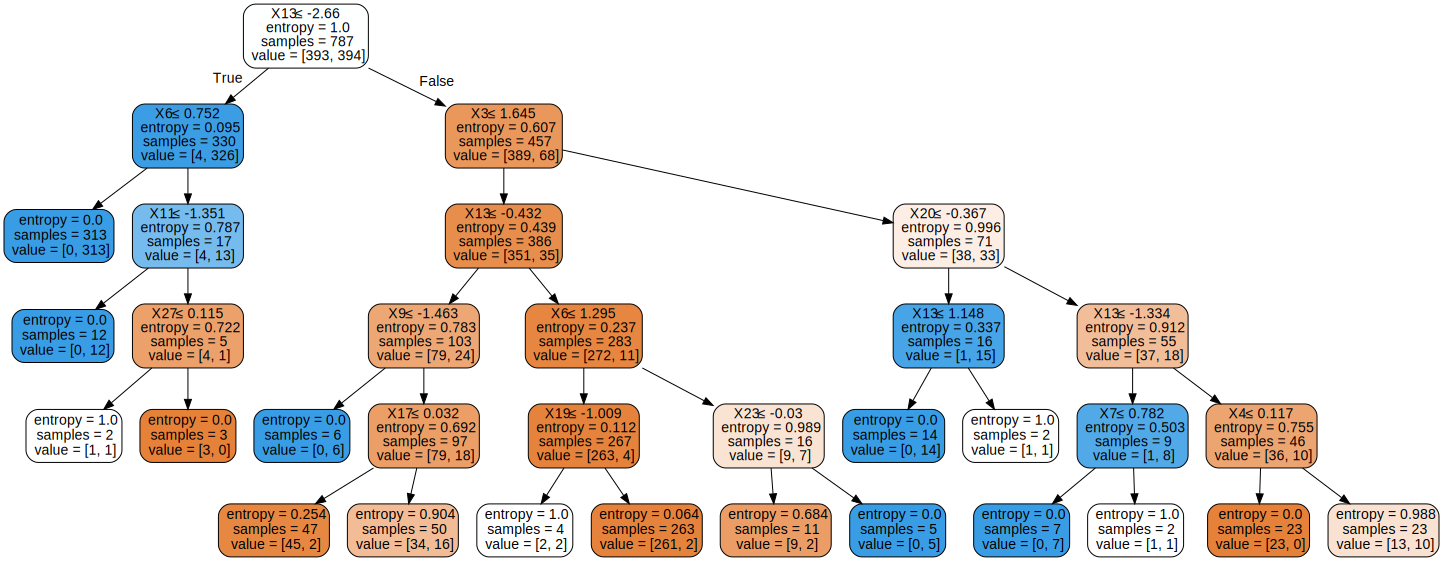

In [23]:
from pathlib import Path
import graphviz

## Build and train the classifier
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=2,criterion='entropy')
dt_model.fit(xtrain, ytrain)

out_file = 'figures/tree_graph.dot'
dot_data = export_graphviz(dt_model,
                          out_file=out_file,
                          max_depth=5,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### <font color="red">Question 1:</font>
1. Train a decision tree with `max_depth=5`. Plot it, if you have graphviz installed, as a graph.
2. Train a decision tree without `max_depth` limitation.


#### 1. Train a decision tree with ``max_depth=5``. Plot it.

#### 2. Train a decision tree without ``max_depth`` limitation. Plot it.

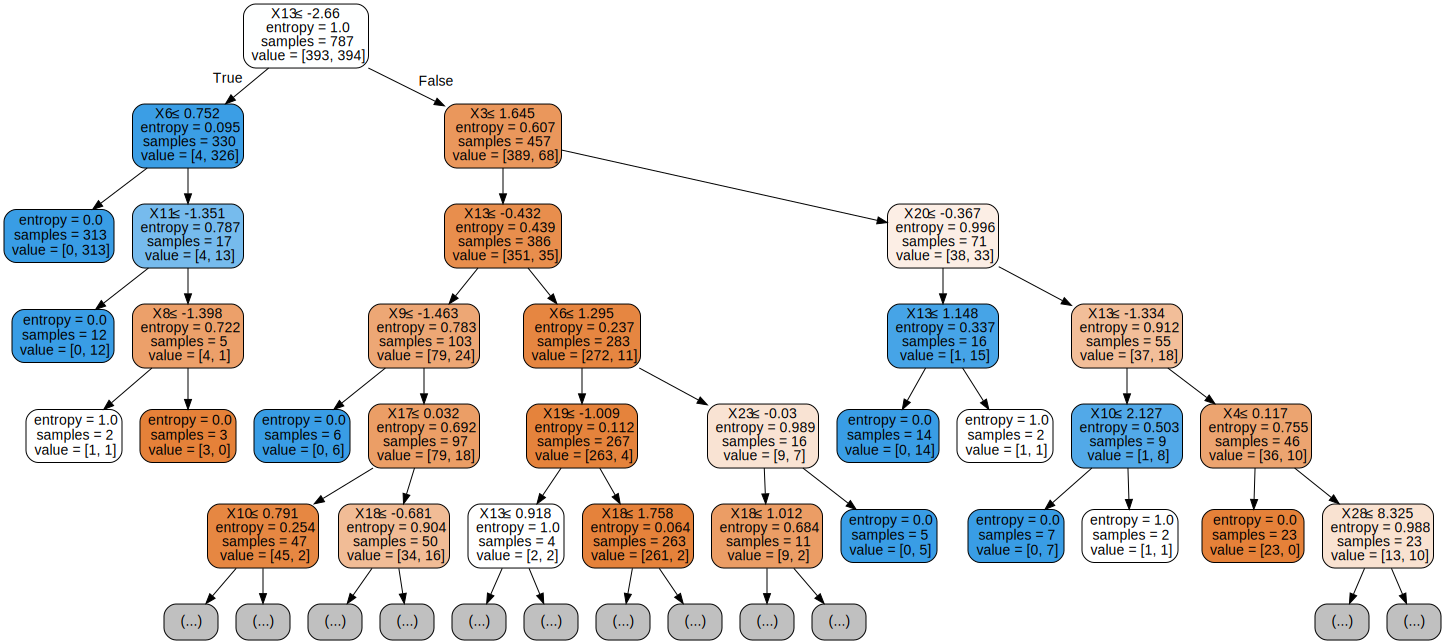

In [54]:
## Build and train the classifier
dt_model = DecisionTreeClassifier(min_samples_leaf=2,criterion='entropy')
dt_model.fit(xtrain, ytrain)

out_file = 'figures/tree_graph.dot'
dot_data = export_graphviz(dt_model,
                          out_file=out_file,
                          max_depth=5,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

# 2. Random Forest

Bagging or bootstrap aggregation is a technique for reducing the variance of an estimated prediction function. Random forests is a substantial modification of bagging that builds a large collection of decorrelated trees, and then averages them.

Let's build a random forest classifier to classify transactions.
- __Objective__: predict whether credit card transactions labeled as fraudulent or genuine.
- __Possible classes__:  Feature 'Class' is the response variable. It takes value 1 in case of fraud and 0 otherwise.
- __Features__: all features

[Document](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier)

In [24]:
# build a random forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=10, criterion='entropy')
rf_model.fit(xtrain,ytrain)

rf_model.score(xtest, ytest)

0.9441624365482234

In [25]:
@interact
def plot_tree_rf(crit=["gini", "entropy"],
                 bootstrap=["True", "False"],
                 depth=IntSlider(min=1,max=30,value=3, continuous_update=False),
                 forests=IntSlider(min=1,max=200,value=100,continuous_update=False),
                 min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
                 min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    
    estimator = RandomForestClassifier(random_state=1,
                                       criterion=crit,
                                       bootstrap=bootstrap,
                                       n_estimators=forests,
                                       max_depth=depth,
                                       min_samples_split=min_split,
                                       min_samples_leaf=min_leaf,
                                       n_jobs=-1,
                                      verbose=False).fit(xtrain, ytrain)

    print('Random Forest Training Accuracy: {:.3f}'.format(accuracy_score(ytrain, estimator.predict(xtrain))))
    print('Random Forest Test Accuracy: {:.3f}'.format(accuracy_score(ytest, estimator.predict(xtest))))
    # Select which tree to plot
    num_tree = estimator.estimators_[0]
    print('\nVisualizing Decision Tree:', 0)
    
    graph = Source(export_graphviz(num_tree,
                                        out_file=None,
                                        feature_names=df_train.iloc[:,:-1].columns,
                                        class_names=['0', '1'],
                                        filled = True))
    
    display(Image(data=graph.pipe(format='png')))
    
    return estimator

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Feature importance

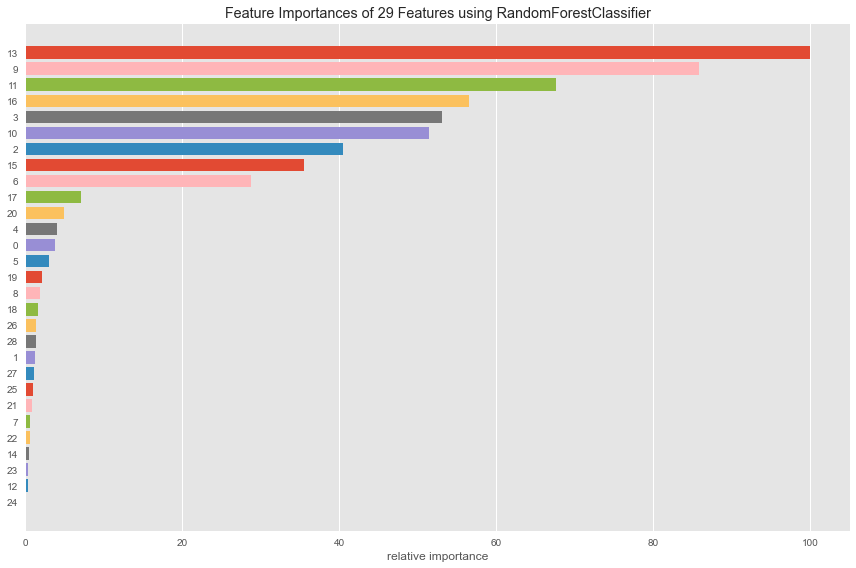

In [26]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

rf = RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=False,
            warm_start=False)

viz = FeatureImportances(rf)
viz.fit(xtrain, ytrain)
viz.show();

# 3.  Boosting

Historically, boosting was considered to be a technique for combining models. Bagging, random forest and boosting are all ensemble learning methods.  

Ensemble learning can be broken down into two tasks: developing a population of base learners from the training data, and then combining them to form the composite predictor.

One major difference of boosting from bagging is that boosting builds the committee of weak learners evolves over time and the members cast a weighted vote. Boosting tree can reduce bias.

[Ensemble learning](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)


## 3.1 Gradient boosting

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

gbt_model = GradientBoostingClassifier()
gbt_model.fit(xtrain,ytrain)

gbt_model.score(xtest, ytest)

0.9543147208121827

### Cross validation 

In [28]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {
                 'n_estimators': [25, 50, 100],
                 'max_depth': [2, 3],
             }

In [29]:
grid_clf = GridSearchCV(gbt_model, param_grid, cv=5)
grid_clf.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [2, 3], 'n_estimators': [25, 50, 100]})

In [30]:
grid_clf.best_estimator_

GradientBoostingClassifier(max_depth=2, n_estimators=50)

In [31]:
grid_clf.best_params_

{'max_depth': 2, 'n_estimators': 50}

In [32]:
grid_clf.cv_results_

{'mean_fit_time': array([0.06322727, 0.11893997, 0.23700781, 0.08402157, 0.17136316,
        0.33893762]),
 'std_fit_time': array([0.00546846, 0.0014371 , 0.00234804, 0.00040623, 0.005498  ,
        0.00243167]),
 'mean_score_time': array([0.0004539 , 0.0004518 , 0.00056219, 0.00041056, 0.00049772,
        0.00064077]),
 'std_score_time': array([7.01189649e-05, 6.84556166e-06, 7.10834508e-05, 6.63129466e-06,
        2.62358387e-05, 7.12811107e-05]),
 'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[25, 50, 100, 25, 50, 100],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 2, 'n_estimators': 25},
  {'max_depth': 2, 'n_estimators': 50},
  {'max_depth': 2, 'n_estimators': 100},
  {'max_depth': 3, 'n_estimators': 25},
  {'max_depth': 3,

In [33]:
gbt_model = GradientBoostingClassifier(max_depth=2)
gbt_model.fit(xtrain,ytrain)

gbt_model.score(xtest, ytest)

0.9644670050761421

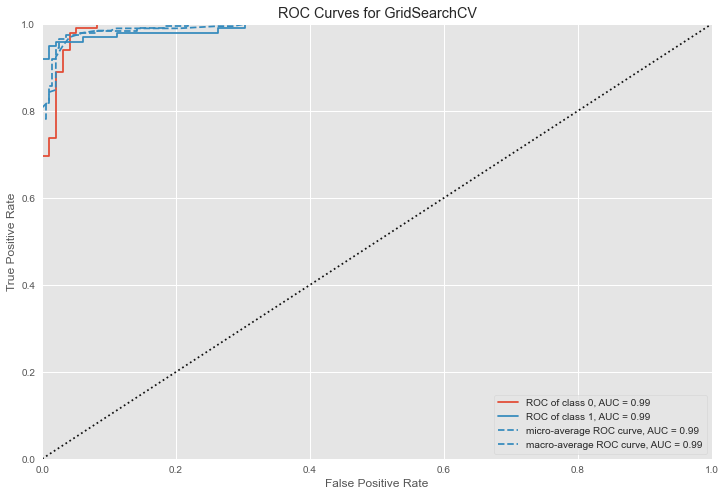

In [34]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(grid_clf)

visualizer.fit(xtrain, ytrain)        # Fit the training data to the visualizer
visualizer.score(xtest, ytest)        # Evaluate the model on the test data
visualizer.poof();

## 3.2 XGBoost

XGBoost stands for eXtreme Gradient Boosting, published by Tianqi Chen in 2016.

In the gradient boosting algorithm, only the first derivative is used to compute the current tree, while XGBoost uses up to the second derivative and have more regularization terms. XGBoost outperforms neural network in some cases which is a very powerful tool in machine learning tasks.


[XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier)

In [35]:
from xgboost import XGBClassifier

# XGBoost
classifier_xgb = XGBClassifier(objective='binary:logistic')

# Randomly search the hyperparameter space
parameters = {

    'min_child_weight':(0,0.1,1,10,100,500),
    'learning_rate':(0.01, 0.1,1),
    'min_split_loss':(0,0.01,0.1,1),
    'max_depth':(2,6,8,10,12),
    'lambda':(0.1,1,2,5,10)
}

Random_XGB = RandomizedSearchCV(classifier_xgb,parameters, cv=5)
Random_XGB.fit(xtrain,ytrain, eval_metric='logloss')

Random_XGB.score(xtest, ytest)

0.9593908629441624

In [36]:
Random_XGB.best_params_

{'min_split_loss': 1,
 'min_child_weight': 0,
 'max_depth': 8,
 'learning_rate': 0.01,
 'lambda': 10}

# 4. Practice

Banking dataset

- __Objective__: predict whether the client subscribe a term deposit or not?
- __Possible classes__:  Feature y “1”, means “Yes”, “0” means “No”
- __Features__: all features

Input Variables

* age (numeric)
* job : type of job (categorical: “admin”, “blue-collar”, “entrepreneur”, “housemaid”, “management”, “retired”, “self-employed”, “services”, “student”, “technician”, “unemployed”, “unknown”)
* marital : marital status (categorical: “divorced”, “married”, “single”, “unknown”)
* education (categorical: “basic.4y”, “basic.6y”, “basic.9y”, “high.school”, “illiterate”, “professional.course”, “university.degree”, “unknown”)
* default: has credit in default? (categorical: “no”, “yes”, “unknown”)
* housing: has housing loan? (categorical: “no”, “yes”, “unknown”)
* loan: has personal loan? (categorical: “no”, “yes”, “unknown”)
* contact: contact communication type (categorical: “cellular”, “telephone”)
* month: last contact month of year (categorical: “jan”, “feb”, “mar”, …, “nov”, “dec”)
* day_of_week: last contact day of the week (categorical: “mon”, “tue”, “wed”, “thu”, “fri”)
* duration: last contact duration, in seconds (numeric). **Important note: this attribute highly affects the output target (e.g., if duration=0 then y=’no’). The duration is not known before a call is performed, also, after the end of the call, y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model**
* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* previous: number of contacts performed before this campaign and for this client (numeric)
* poutcome: outcome of the previous marketing campaign (categorical: “failure”, “nonexistent”, “success”)
* emp.var.rate: employment variation rate — (numeric)
* cons.price.idx: consumer price index — (numeric)
* cons.conf.idx: consumer confidence index — (numeric)
* euribor3m: euribor 3 month rate — (numeric)
* nr.employed: number of employees — (numeric)

Predict variable (desired target):

* y — has the client subscribed a term deposit? (binary: “1”, means “Yes”, “0” means “No”)



The education column of the dataset has many categories and we need to reduce the categories for a better modelling. The education column has the following categories:


Let us group “basic.4y”, “basic.9y” and “basic.6y” together and call them “basic”.




Here is a list of tasks that you need to complete:

1. Read the 'data/banking.csv' file into a dataframe and drop the "duration" column (see above)

2. The education column has multiple entries that are very similar. Let's group “basic.4y”, “basic.9y” and “basic.6y” together and call them “basic”.

2. Use get_dummies() to "one-hot encode" the categorical variables (think carefully about how you handle drop_first).

1. Split the dataset into training and testing datasets.  

2. Create a random forest classifier for ```y```.  Use all the features in the dataset. Use 10 decision trees and use 'entropy' as the criterion.  Fit the model to your training data set.

3. Add a column of predicted labels to the test dataset based on your predictions from the random forest classifier you fitted in the previous step.

4. Report the accuracy of your model.

5. Extract the feature importances from your model and plot them in a bar chart.  Identify the most important features in your model.

6. Tune your random forest model by varying the number of decision trees (n_estimators) and tree depth (max_depth).  Report the best hyperparameters and the accuracy obtained by using those hyperparameters.

#### 1. Read the 'data/banking.csv' file into a dataframe and drop the "duration" column (see above)

In [37]:
# Read the 'data/banking.csv' file into a dataframe and drop the "duration" column (see above)

import pandas as pd
banking = pd.read_csv('data/banking.csv')
# Add your code to drop duration column
banking.drop(["duration"], inplace=True,axis=1)
banking.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [38]:
banking.shape

(41188, 20)

#### 2. The education column has multiple entries that are very similar. Let's group “basic.4y”, “basic.9y” and “basic.6y” together and call them “basic”.

In [39]:
# Add your code to group the column "education"
#“basic.4y”, “basic.9y” and “basic.6y”

def rep_basic(row):
    if row.education=="basic.4y" or row.education=="basic.6y" or row.education=="basic.9y":
        return "basic"
    else:
        return row.education
    
banking.education = banking.apply(rep_basic,axis=1)


In [40]:
banking.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic,unknown,yes,no,cellular,aug,thu,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic,no,yes,no,cellular,aug,fri,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


#### 3. Use get_dummies() to "one-hot encode" the categorical variables (think carefully about how you handle drop_first).

In [41]:
# Add your code to create dummy variables

data_final = pd.get_dummies(banking) 
# drop_first = True
# get k-1 dummies out of k categorical levels by removing the first level


#### 4. Split the dataset into training and testing datasets: ``data_train_X``, ``data_train_y``, ``data_test_X``, ``data_test_y``. 

In [42]:
# Add your code for data splitting (train_test_split)

data_train, data_test = train_test_split(data_final, test_size=0.3)
data_train_X = data_train.drop("y",axis=1)
data_train_y = data_train[["y"]]

data_test_X = data_test.drop("y",axis=1)
data_test_y = data_test[["y"]]


#### 5. Create a random forest classifier for y ``rf_model``. Use all the features in the dataset. Use ``10`` decision trees and use ``entropy`` as the criterion. Fit the model to your training data set.

In [43]:
# build a random forest

rf_model = RandomForestClassifier(n_estimators=10, criterion='entropy')
rf_model.fit(data_train_X,data_train_y)


RandomForestClassifier(criterion='entropy', n_estimators=10)

#### 6. Add a column of predicted labels ``predicted_rf_tree`` to the test dataset based on your predictions from the random forest classifier you fitted in the previous step.

In [44]:
# now do the predicting... use the same approach as you did in testing the Decision Tree Classifier above,
# but don't include the .sample() line
# this is testing the model 

predicted_labels = rf_model.predict(data_test_X)
data_test_X['predicted_rf_tree'] = predicted_labels


#### 7. Report the accuracy of your model.

In [45]:

rf_model.score(data_test_X.drop("predicted_rf_tree",axis=1),data_test_y)


0.8908311078740795

#### 8. Extract the feature importances from your model and plot them in a bar chart. Identify the most important features in your model.

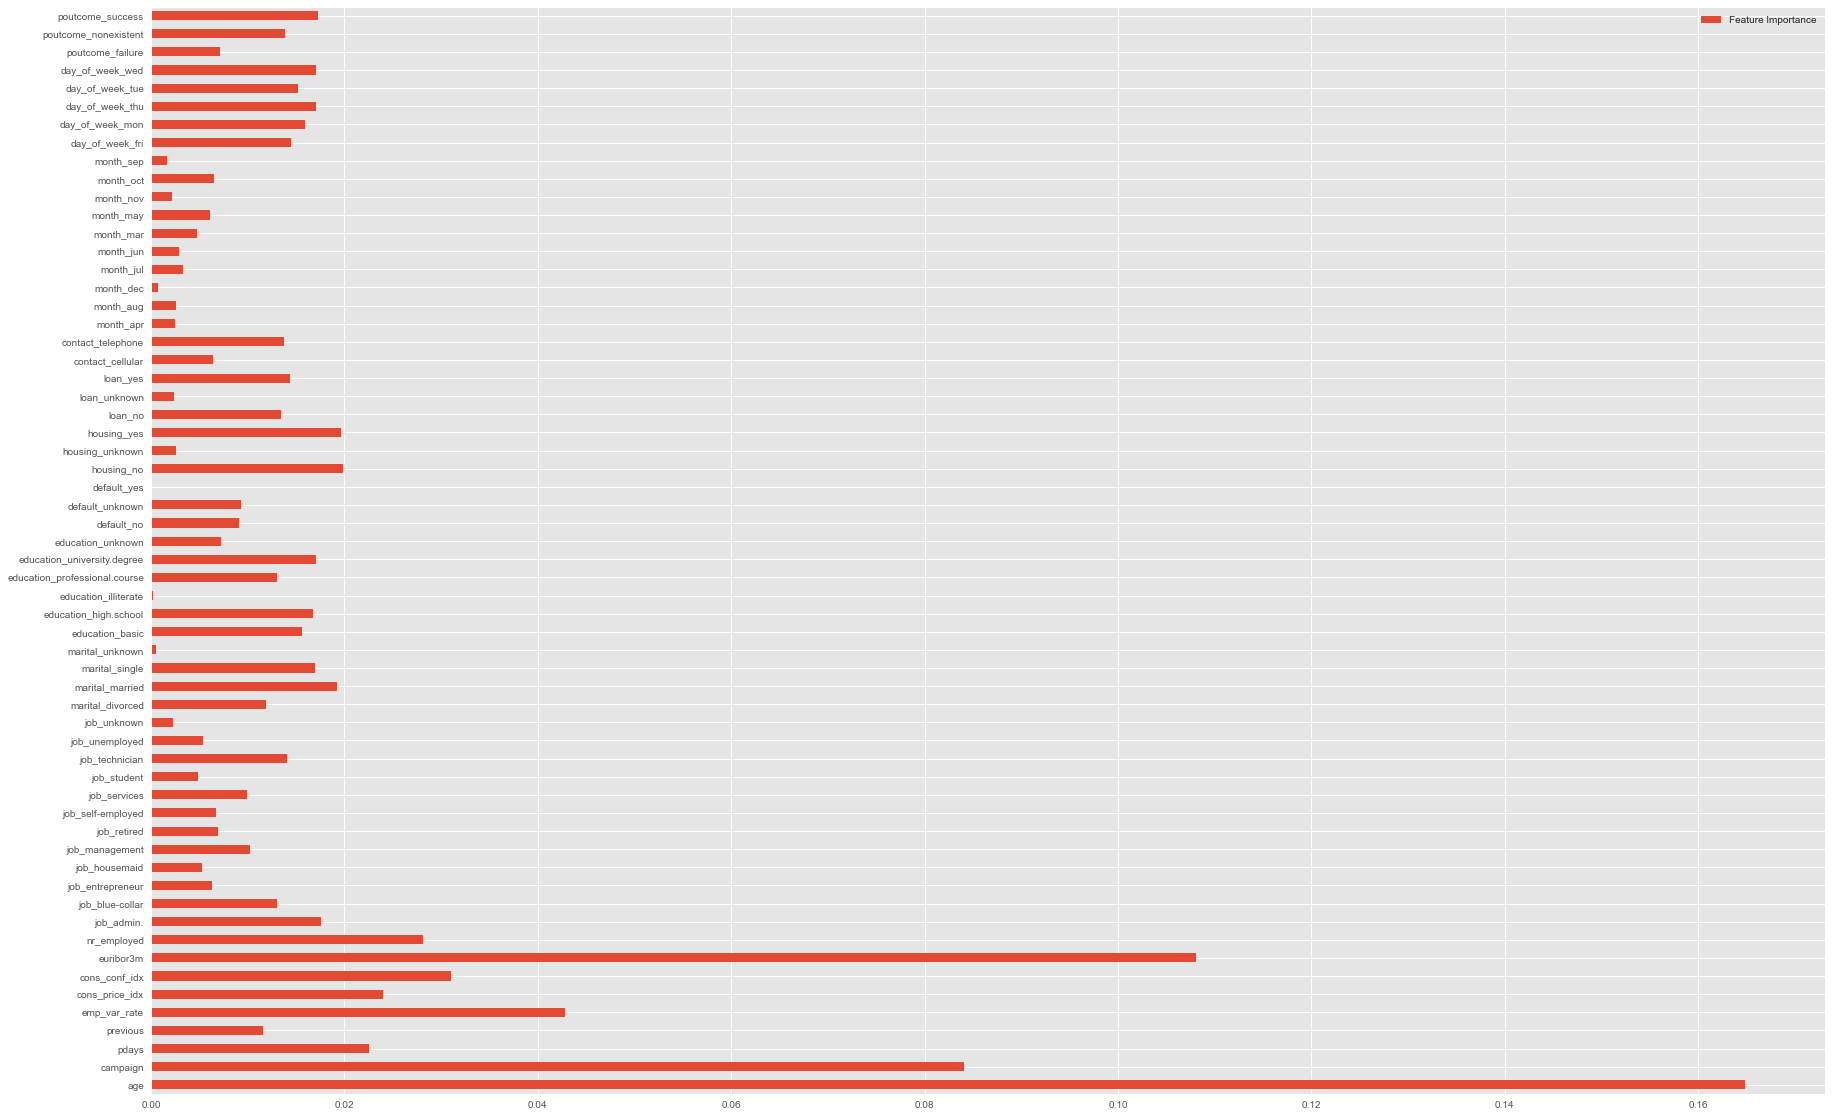

In [46]:
# Check feature importance

feat_importance = rf_model.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance},
            index=data_train_X.columns).plot(kind='barh', figsize=(30,20))


#### 9. Tune your random forest model by varying the number of decision trees (n_estimators) and tree depth (max_depth). Report the best hyperparameters and the accuracy obtained by using those hyperparameters.

In [47]:
# Model Selection and Comparison

In [48]:
%%time
# Model Selection and Comparison
param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25],
                 'max_depth': [2, 5, 7, 9],
             }

grid_clf = GridSearchCV(rf_model, param_grid, cv=10)
grid_clf.fit(data_train_X, data_train_y)


CPU times: user 23.2 s, sys: 909 ms, total: 24.1 s
Wall time: 24.1 s


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(criterion='entropy',
                                              n_estimators=10),
             param_grid={'max_depth': [2, 5, 7, 9],
                         'n_estimators': [5, 10, 15, 20, 25]})

In [55]:
best_model

RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=25)

In [49]:
best_model = grid_clf.best_estimator_
data_train_X = data_train.drop("y",axis=1)
data_train_y = data_train[["y"]]

data_test_X = data_test.drop("y",axis=1)
data_test_y = data_test[["y"]]
# build best random forest
best_model.fit(data_train_X, data_train_y)

best_model.score(data_test_X, data_test_y)

0.9024034959941734

In [50]:
predicted_labels = rf_model.predict(data_test_X)
data_test_X['predicted_rf_tree'] = predicted_labels

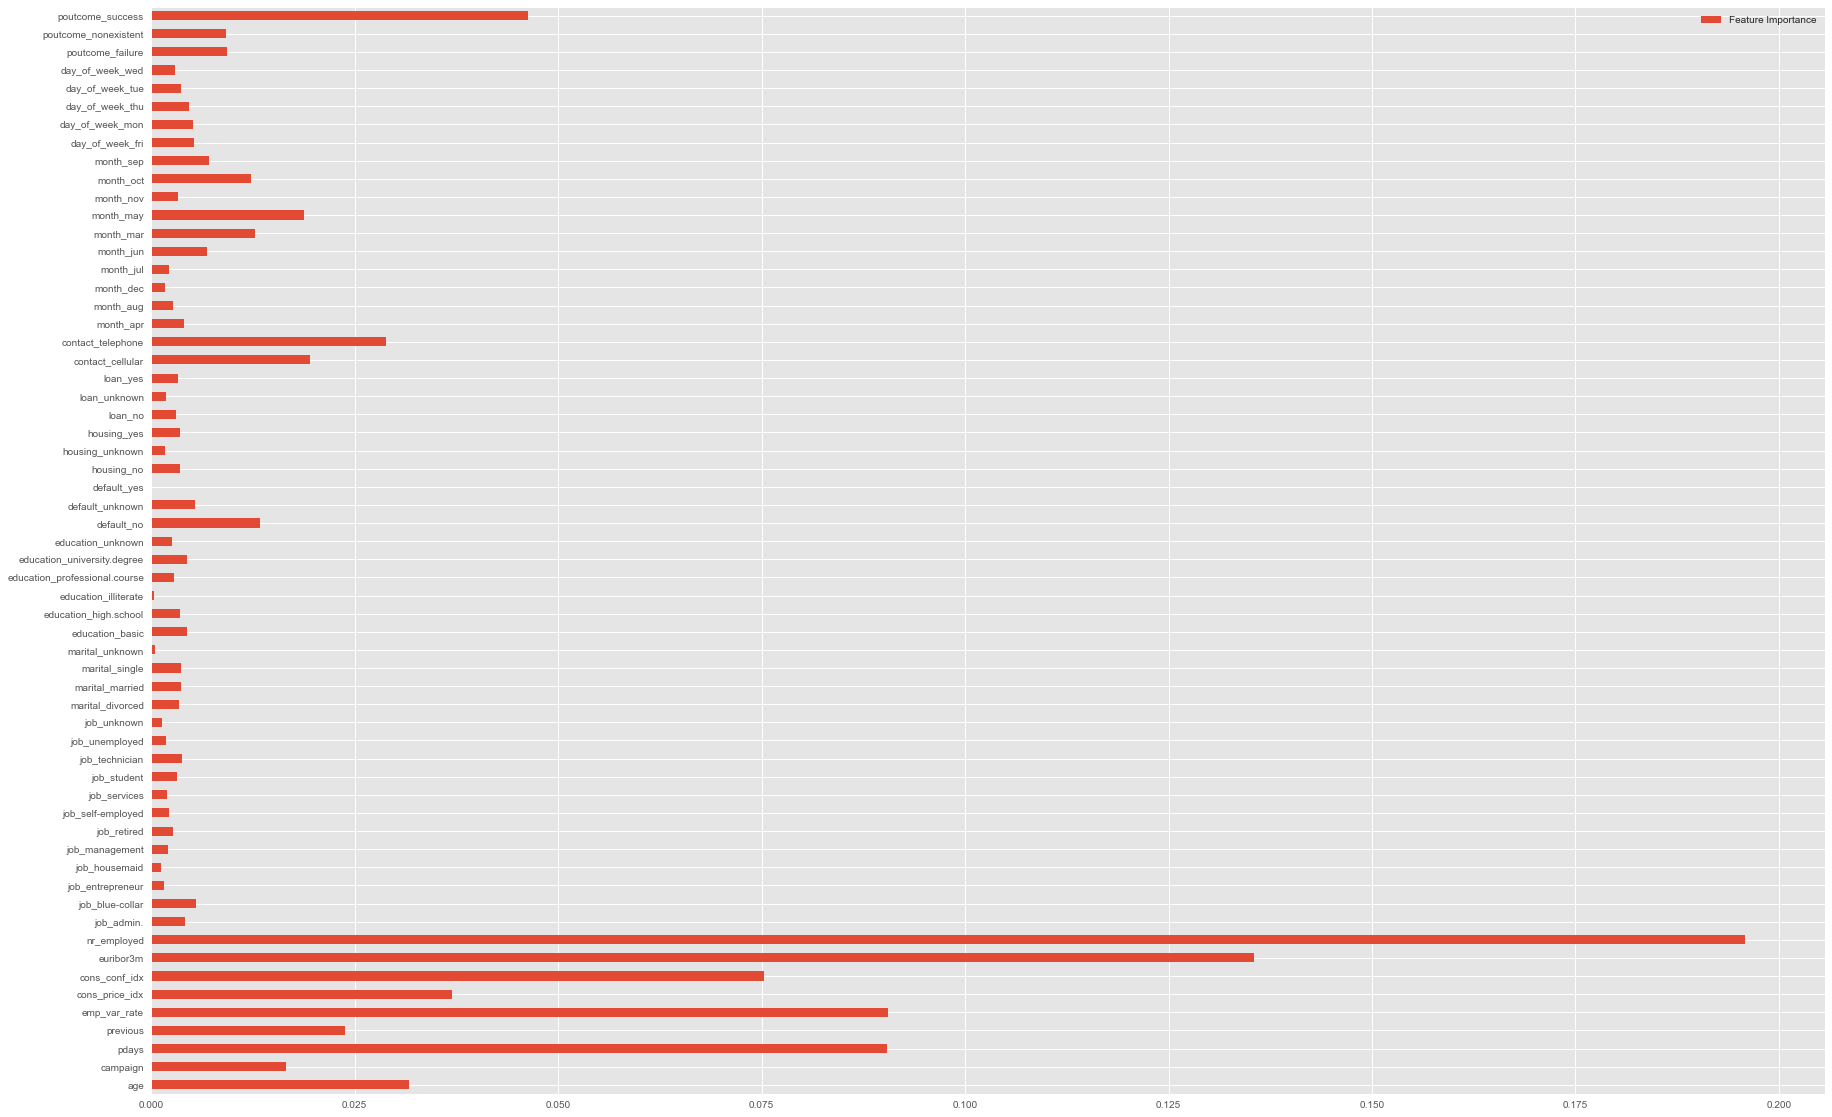

In [51]:
feat_importance = best_model.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance},
            index=data_train_X.columns).plot(kind='barh', figsize=(30,20))

### Visualization of the CV results

In [52]:

from sklearn.model_selection import cross_val_score

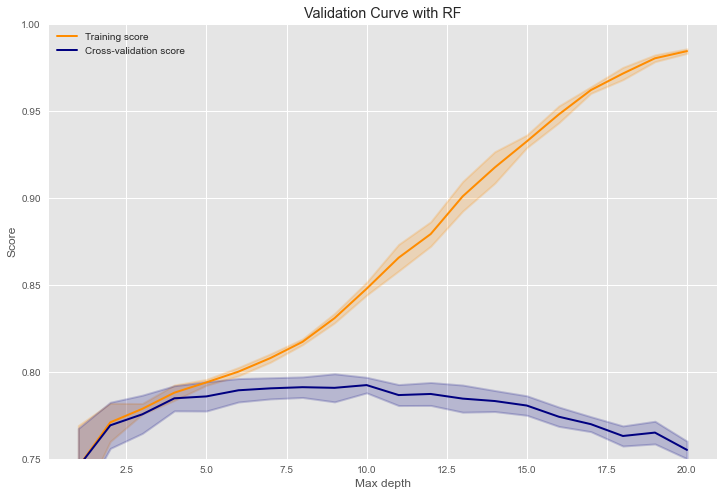

In [53]:
from sklearn.model_selection import validation_curve
param_range = np.linspace(1, 20, 20)
train_scores, test_scores = validation_curve(
    RandomForestClassifier(
                                            n_estimators=10, 
                                            oob_score=True, 
                                            criterion='entropy'),
    data_train_X, data_train_y, param_name="max_depth", param_range=param_range,
    scoring="roc_auc", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RF")
plt.xlabel("Max depth")
plt.ylabel("Score")
plt.ylim(0.75, 1.0)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()